<a href="https://colab.research.google.com/github/BrendaLoznik/BigBangTheory/blob/main/Bang_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1 Housekeeping**

### **1.1 Load libraries**

In [32]:
pip install afinn

In [52]:
#basic libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import re

#pre-processing
import nltk
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords
import string    #string.punctuation 

#sentiment
from afinn import Afinn

pd.set_option("display.max_columns", 100)
pd.set_option("display.max_rows", 200)
#pd.set_option('display.max_colwidth', None)

#gensim
from gensim.corpora.dictionary import Dictionary
from collections import defaultdict
import itertools   
from gensim.models.tfidfmodel import TfidfModel

#ml
from sklearn.feature_extraction.text import CountVectorizer, ENGLISH_STOP_WORDS
from sklearn.feature_extraction.text import TfidfVectorizer

#spacy
import spacy
nlp = spacy.load('en')
nlp = spacy.load('en_core_web_sm')

In [3]:
nltk.download('punkt')
nltk.download('stopwords')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

### ***1.2 Load data***

In [8]:
from google.colab import drive 

In [9]:
#df: one line per paragraph
df = pd.read_csv('/content/drive/MyDrive/Kaggle/Bigbang/cleaned_episodes2.csv', sep = '|')
df = df.dropna()
df.head()

,episode_nr,season,season_episode,episode_id,episode_name,character,location,line,line_id
0,1,1,1,1-1,Pilot Episode,Sheldon,A corridor at a sperm bank.,So if a photon is directed through a plane wit...,1
1,1,1,1,1-1,Pilot Episode,Leonard,A corridor at a sperm bank.,"Agreed, what’s your point?",2
2,1,1,1,1-1,Pilot Episode,Sheldon,A corridor at a sperm bank.,"There’s no point, I just think it’s a good ide...",3
3,1,1,1,1-1,Pilot Episode,Leonard,A corridor at a sperm bank.,Excuse me?,4
4,1,1,1,1-1,Pilot Episode,Receptionist,A corridor at a sperm bank.,Hang on.,5


In [70]:
cleaned_df = pd.read_csv('/content/drive/MyDrive/Kaggle/Bigbang/processed_cleaned.csv')
cleaned_df.head()

,episode_nr,season,season_episode,episode_id,episode_name,character,location,line,line_id,cleaned_line_1,cleaned_line_2
0,1,1,1,1-1,Pilot Episode,Sheldon,A corridor at a sperm bank.,So if a photon is directed through a plane wit...,1,photon direct plane slit slit observe slit s u...,photon direct plane slit slit observe slit uno...
1,1,1,1,1-1,Pilot Episode,Leonard,A corridor at a sperm bank.,"Agreed, what’s your point?",2,agree s point,agree point
2,1,1,1,1-1,Pilot Episode,Sheldon,A corridor at a sperm bank.,"There’s no point, I just think it’s a good ide...",3,s point think s good idea tee shirt,point think good idea tee shirt
3,1,1,1,1-1,Pilot Episode,Leonard,A corridor at a sperm bank.,Excuse me?,4,excuse,excuse
4,1,1,1,1-1,Pilot Episode,Receptionist,A corridor at a sperm bank.,Hang on.,5,hang,hang


# **2 Analysis**

### **2.1 Dialogues of mains**

In [12]:
#create a list of the 10 characters with the most dialogues
main_dialogues = df.copy()
top = main_dialogues['character'].value_counts().nlargest(8).index.tolist()

#main_dialogues.loc[~main_dialogues['character'].isin(top), "character"] = 'Other'
main_dialogues = main_dialogues[main_dialogues['character'].isin(top)]
main_dialogues.head()

,episode_nr,season,season_episode,episode_id,episode_name,character,location,line,line_id
0,1,1,1,1-1,Pilot Episode,Sheldon,A corridor at a sperm bank.,So if a photon is directed through a plane wit...,1
1,1,1,1,1-1,Pilot Episode,Leonard,A corridor at a sperm bank.,"Agreed, what’s your point?",2
2,1,1,1,1-1,Pilot Episode,Sheldon,A corridor at a sperm bank.,"There’s no point, I just think it’s a good ide...",3
3,1,1,1,1-1,Pilot Episode,Leonard,A corridor at a sperm bank.,Excuse me?,4
5,1,1,1,1-1,Pilot Episode,Leonard,A corridor at a sperm bank.,"One across is Aegean, eight down is Nabakov, t...",6


In [13]:
grouped = main_dialogues.groupby(['episode_nr', 'character']).size().reset_index(name='counts') #size is useful for the nubmer of rows in a grupby
grouped.head()

,episode_nr,character,counts
0,1,Howard,18
1,1,Leonard,126
2,1,Penny,61
3,1,Raj,3
4,1,Sheldon,104


In [14]:
 #pivot and flatten df
pivot = grouped.pivot_table(index = 'episode_nr', columns = 'character', fill_value = 0)
mi=pivot.columns
mi.tolist()
ind = pd.Index([ str(e[1])  for e in mi.tolist()])
pivot.columns = ind
pivot

#create relative columns
pivot['total'] = pivot['Amy'] + pivot['Bernadette'] + pivot['Howard'] + pivot['Leonard'] + pivot ['Penny'] + pivot['Raj'] + pivot['Sheldon'] + pivot['Stuart']
pivot['Amy%'] = round((pivot['Amy'] / pivot['total'])*100,1)
pivot['Bernadette%'] = round((pivot['Bernadette'] / pivot['total'])*100,1)
pivot['Howard%'] = round((pivot['Howard'] / pivot['total'])*100,1)
pivot['Leonard%'] = round((pivot['Leonard'] / pivot['total'])*100,1)
pivot['Penny%'] = round((pivot['Penny'] / pivot['total'])*100,1)
pivot['Raj%'] = round((pivot['Raj'] / pivot['total'])*100,1)
pivot['Sheldon%'] = round((pivot['Sheldon'] / pivot['total'])*100,1)
pivot['Stuart%'] = round((pivot['Stuart'] / pivot['total'])*100,1)



pivot.head()

,Amy,Bernadette,Howard,Leonard,Penny,Raj,Sheldon,Stuart,total,Amy%,Bernadette%,Howard%,Leonard%,Penny%,Raj%,Sheldon%,Stuart%
episode_nr,,,,,,,,,,,,,,,,,
1,0,0,18,126,61,3,104,0,312,0.0,0.0,5.8,40.4,19.6,1.0,33.3,0.0
2,0,0,20,85,48,10,71,0,234,0.0,0.0,8.5,36.3,20.5,4.3,30.3,0.0
3,0,0,25,106,39,10,49,0,229,0.0,0.0,10.9,46.3,17.0,4.4,21.4,0.0
4,0,0,6,47,31,2,84,0,170,0.0,0.0,3.5,27.6,18.2,1.2,49.4,0.0
5,0,0,11,70,38,6,57,0,182,0.0,0.0,6.0,38.5,20.9,3.3,31.3,0.0


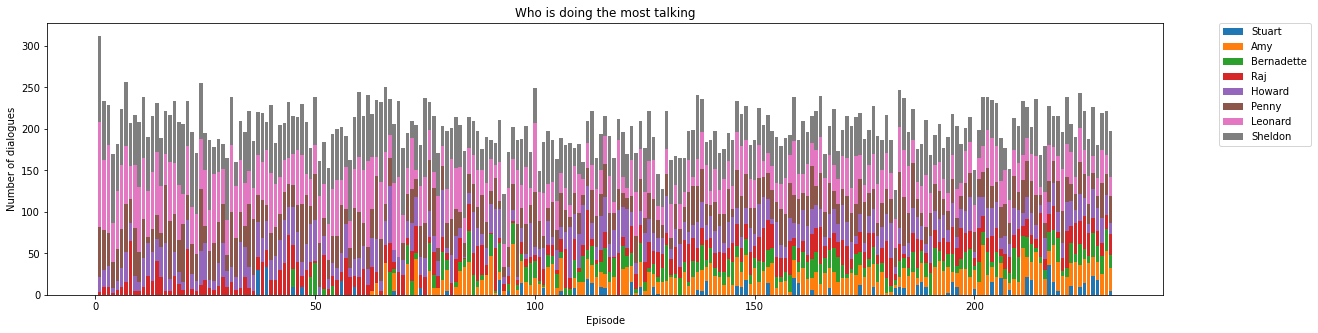

In [15]:
#absolute number of dialogues(paragraphs) per episode
fig, ax = plt.subplots(figsize=(20,5))
labels = pivot.index
ax.bar(labels, pivot['Stuart'], label = 'Stuart')
ax.bar (labels,  pivot['Amy'], label = 'Amy', bottom = pivot['Stuart']  )
ax.bar(labels, pivot['Bernadette'], label = 'Bernadette', bottom = pivot['Stuart']+ pivot['Amy'])
ax.bar(labels, pivot['Raj'], label = 'Raj', bottom = pivot['Stuart']+ pivot['Amy'] + pivot['Bernadette'])
ax.bar(labels, pivot['Howard'], label = 'Howard', bottom = pivot['Stuart']+ pivot['Amy'] + pivot['Bernadette'] + pivot['Raj'])
ax.bar(labels, pivot['Penny'], label = 'Penny', bottom = pivot['Stuart']+ pivot['Amy'] + pivot['Bernadette'] + pivot['Raj'] + pivot['Howard'])
ax.bar(labels, pivot['Leonard'], label = 'Leonard', bottom = pivot['Stuart']+ pivot['Amy'] + pivot['Bernadette'] + pivot['Raj'] + pivot['Howard'] + pivot['Penny'])
ax.bar(labels, pivot['Sheldon'], label = 'Sheldon',  bottom = pivot['Stuart']+ pivot['Amy'] + pivot['Bernadette'] + pivot['Raj'] + pivot['Howard'] + pivot['Penny'] + pivot['Leonard'])
ax.set(title = 'Who is doing the most talking', xlabel = 'Episode', ylabel = 'Number of dialogues')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

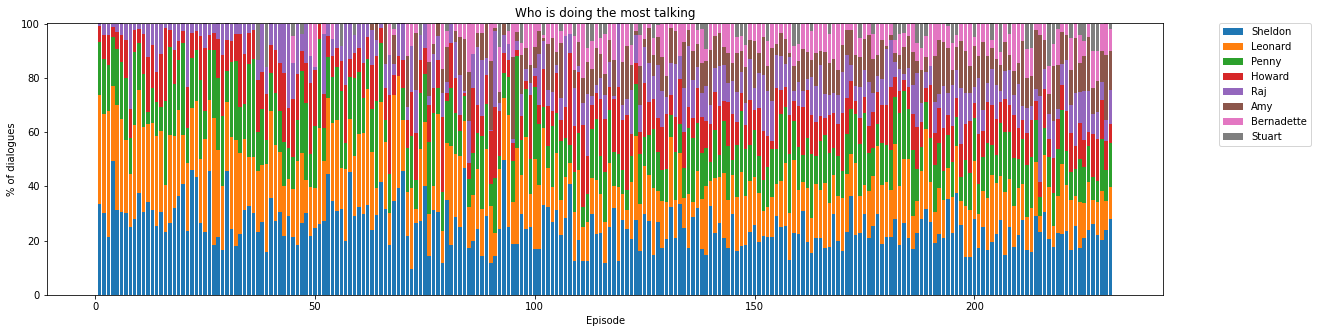

In [16]:
#relative number of paragraphs per episode
fig, ax = plt.subplots(figsize=(20,5))
labels = pivot.index
ax.bar(labels, pivot['Sheldon%'], label = 'Sheldon')
ax.bar (labels,  pivot['Leonard%'], label = 'Leonard', bottom = pivot['Sheldon%']  )
ax.bar(labels, pivot['Penny%'], label = 'Penny', bottom = pivot['Sheldon%'] + pivot['Leonard%'])
ax.bar(labels, pivot['Howard%'], label = 'Howard', bottom = pivot['Sheldon%'] + pivot['Leonard%'] + pivot['Penny%'])
ax.bar(labels, pivot['Raj%'], label = 'Raj',  bottom = pivot['Sheldon%'] + pivot['Leonard%'] + pivot['Penny%'] + pivot['Howard%'])
ax.bar(labels, pivot['Amy%'], label = 'Amy',  bottom = pivot['Sheldon%'] + pivot['Leonard%'] + pivot['Penny%'] + pivot['Howard%'] + pivot['Raj%'])
ax.bar(labels, pivot['Bernadette%'], label = 'Bernadette', bottom = pivot['Sheldon%'] + pivot['Leonard%'] + pivot['Penny%'] + pivot['Howard%'] + pivot['Raj%'] +  pivot['Amy%'])
ax.bar(labels, pivot['Stuart%'], label = 'Stuart',   bottom = pivot['Sheldon%'] + pivot['Leonard%'] + pivot['Penny%'] + pivot['Howard%'] + pivot['Raj%'] +  pivot['Amy%'] + pivot['Bernadette%'])
ax.set(title = 'Who is doing the most talking', xlabel = 'Episode', ylabel = '% of dialogues')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

### **2.2 Word count of mains**

In [17]:
# Tokenize each line in the line column and only keep alphanumeric
word_tokens = [word_tokenize(line) for line in main_dialogues.line]
let_digits = [[word for word in item if word.isalnum()] for item in word_tokens]

# Create an empty list to store the length of the line (punctuation included)
len_tokens = []

# Iterate over the word_tokens list and determine the length of each item
for i in range(len(let_digits)):
     len_tokens.append(len(let_digits[i]))

# Create a new feature for the lengh of each line
main_words = main_dialogues.copy()

main_words['n_words'] = len_tokens 

main_words.head(5)

,episode_nr,season,season_episode,episode_id,episode_name,character,location,line,line_id,n_words
0,1,1,1,1-1,Pilot Episode,Sheldon,A corridor at a sperm bank.,So if a photon is directed through a plane wit...,1,57
1,1,1,1,1-1,Pilot Episode,Leonard,A corridor at a sperm bank.,"Agreed, what’s your point?",2,5
2,1,1,1,1-1,Pilot Episode,Sheldon,A corridor at a sperm bank.,"There’s no point, I just think it’s a good ide...",3,14
3,1,1,1,1-1,Pilot Episode,Leonard,A corridor at a sperm bank.,Excuse me?,4,2
5,1,1,1,1-1,Pilot Episode,Leonard,A corridor at a sperm bank.,"One across is Aegean, eight down is Nabakov, t...",6,29


In [49]:
#groupby season and character and sum the word count
word_group = main_words.groupby(['season', 'character'])['n_words'].sum().reset_index()
word_group.head()

,season,character,n_words
0,1,Howard,5014
1,1,Leonard,12237
2,1,Penny,7194
3,1,Raj,2887
4,1,Sheldon,15662


In [50]:
 #pivot and flatten df
word_pivot = word_group.pivot_table(index = 'season', columns = 'character', fill_value = 0)
mi=word_pivot .columns
mi.tolist()
ind = pd.Index([ str(e[1])  for e in mi.tolist()])
word_pivot .columns = ind

#create relative columns
word_pivot ['total'] = word_pivot ['Amy'] + word_pivot ['Bernadette'] + word_pivot ['Howard'] + word_pivot ['Leonard'] +word_pivot  ['Penny'] + word_pivot ['Raj'] + word_pivot ['Sheldon'] + word_pivot ['Stuart']
word_pivot ['Amy%'] = round((word_pivot ['Amy'] / word_pivot ['total'])*100,1)
word_pivot ['Bernadette%'] = round((word_pivot ['Bernadette'] / word_pivot ['total'])*100,1)
word_pivot ['Howard%'] = round((word_pivot ['Howard'] / word_pivot ['total'])*100,1)
word_pivot ['Leonard%'] = round((word_pivot ['Leonard'] / word_pivot ['total'])*100,1)
word_pivot ['Penny%'] = round((word_pivot ['Penny'] / word_pivot ['total'])*100,1)
word_pivot ['Raj%'] = round((word_pivot ['Raj'] / word_pivot ['total'])*100,1)
word_pivot ['Sheldon%'] = round((word_pivot ['Sheldon'] / word_pivot ['total'])*100,1)
word_pivot ['Stuart%'] = round((word_pivot ['Stuart'] / word_pivot ['total'])*100,1)

word_pivot .head()

,Amy,Bernadette,Howard,Leonard,Penny,Raj,Sheldon,Stuart,total,Amy%,Bernadette%,Howard%,Leonard%,Penny%,Raj%,Sheldon%,Stuart%
season,,,,,,,,,,,,,,,,,
1,0,0,5014,12237,7194,2887,15662,0,42994,0.0,0.0,11.7,28.5,16.7,6.7,36.4,0.0
2,0,0,7396,12452,9568,3797,20972,578,54763,0.0,0.0,13.5,22.7,17.5,6.9,38.3,1.1
3,103,795,7343,11671,8212,6383,21073,505,56085,0.2,1.4,13.1,20.8,14.6,11.4,37.6,0.9
4,4924,2533,6643,10128,7581,5442,20292,213,57756,8.5,4.4,11.5,17.5,13.1,9.4,35.1,0.4
5,5974,3572,7380,9959,7595,4954,18198,674,58306,10.2,6.1,12.7,17.1,13.0,8.5,31.2,1.2


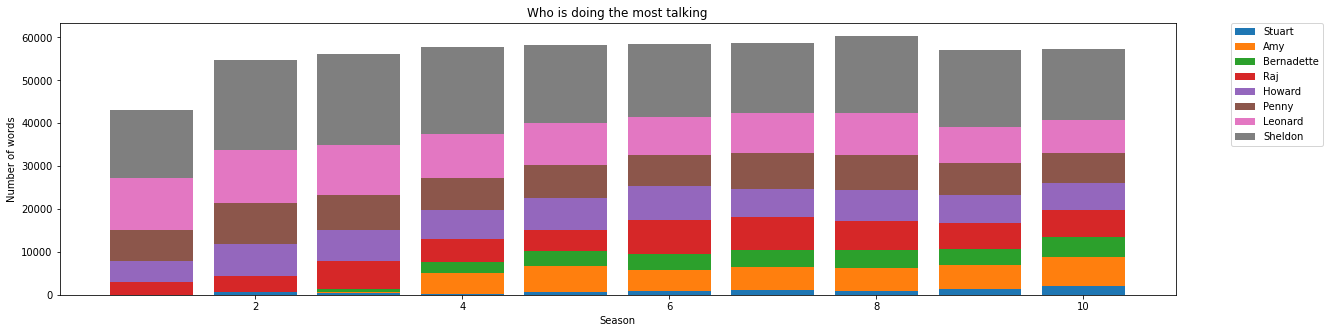

In [54]:
#absolute number of words per season
fig, ax = plt.subplots(figsize=(20,5))
labels = word_pivot .index
ax.bar(labels, word_pivot ['Stuart'], label = 'Stuart')
ax.bar (labels, word_pivot ['Amy'], label = 'Amy', bottom = word_pivot ['Stuart']  )
ax.bar(labels, word_pivot ['Bernadette'], label = 'Bernadette', bottom = word_pivot ['Stuart']+ word_pivot ['Amy'])
ax.bar(labels, word_pivot ['Raj'], label = 'Raj', bottom = word_pivot ['Stuart']+ word_pivot ['Amy'] + word_pivot ['Bernadette'])
ax.bar(labels, word_pivot ['Howard'], label = 'Howard', bottom = word_pivot ['Stuart']+ word_pivot ['Amy'] + word_pivot ['Bernadette'] + word_pivot ['Raj'])
ax.bar(labels, word_pivot ['Penny'], label = 'Penny', bottom = word_pivot ['Stuart']+ word_pivot ['Amy'] + word_pivot ['Bernadette'] + word_pivot ['Raj'] + word_pivot ['Howard'])
ax.bar(labels, word_pivot ['Leonard'], label = 'Leonard', bottom = word_pivot ['Stuart']+ word_pivot ['Amy'] + word_pivot ['Bernadette'] + word_pivot ['Raj'] + word_pivot ['Howard'] + word_pivot ['Penny'])
ax.bar(labels, word_pivot ['Sheldon'], label = 'Sheldon',  bottom = word_pivot ['Stuart']+ word_pivot ['Amy'] + word_pivot ['Bernadette'] + word_pivot ['Raj'] + word_pivot ['Howard'] + word_pivot ['Penny'] + word_pivot ['Leonard'])
ax.set(title = 'Who is doing the most talking', xlabel = 'Season', ylabel = 'Number of words')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

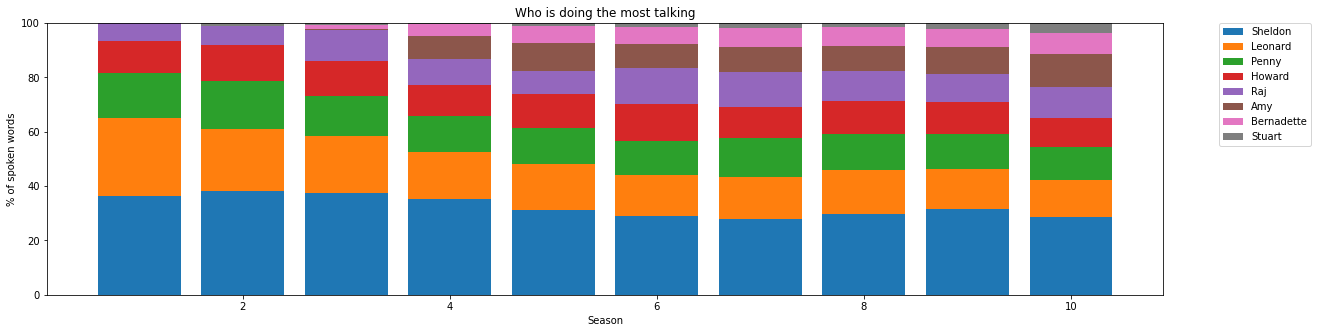

In [53]:
#relative number of paragraphs per  season
fig, ax = plt.subplots(figsize=(20,5))
labels =  word_pivot.index
ax.bar(labels,  word_pivot['Sheldon%'], label = 'Sheldon')
ax.bar (labels,   word_pivot['Leonard%'], label = 'Leonard', bottom =  word_pivot['Sheldon%']  )
ax.bar(labels,  word_pivot['Penny%'], label = 'Penny', bottom =  word_pivot['Sheldon%'] +  word_pivot['Leonard%'])
ax.bar(labels,  word_pivot['Howard%'], label = 'Howard', bottom =  word_pivot['Sheldon%'] +  word_pivot['Leonard%'] +  word_pivot['Penny%'])
ax.bar(labels,  word_pivot['Raj%'], label = 'Raj',  bottom =  word_pivot['Sheldon%'] +  word_pivot['Leonard%'] +  word_pivot['Penny%'] +  word_pivot['Howard%'])
ax.bar(labels,  word_pivot['Amy%'], label = 'Amy',  bottom = word_pivot['Sheldon%'] +  word_pivot['Leonard%'] + word_pivot['Penny%'] +  word_pivot['Howard%'] +  word_pivot['Raj%'])
ax.bar(labels,  word_pivot['Bernadette%'], label = 'Bernadette', bottom = word_pivot['Sheldon%'] +  word_pivot['Leonard%'] +  word_pivot['Penny%'] +  word_pivot['Howard%'] +  word_pivot['Raj%'] +   word_pivot['Amy%'])
ax.bar(labels,  word_pivot['Stuart%'], label = 'Stuart',   bottom =  word_pivot['Sheldon%'] +  word_pivot['Leonard%'] + word_pivot['Penny%'] +  word_pivot['Howard%'] + word_pivot['Raj%'] +  word_pivot['Amy%'] +  word_pivot['Bernadette%'])
ax.set(title = 'Who is doing the most talking', xlabel = 'Season', ylabel = '% of spoken words')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

#### **Mean word length**

In [ ]:
#note: punctuation is now part of the word length
main_words['mean_word_length'] = main_words['line'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
main_words.head()

#### **Punctuation count**

In [29]:
#string.puncutation is a list of all sorts of punctuations. 'there's ' is counted as puncutation
main_words['punctuation_count'] = main_words['line'].apply( lambda x: len([ w for w in str(x) if w in string.punctuation ]))


####**count stopwords**

In [40]:
#nltk has 179 stopwords
#spacy has 362
main_words['stopword_count_nltk'] = main_words['line']. apply (lambda x: len([w for w in str(x).lower().split() if w in stopwords.words('english')]))


In [54]:
spacy_stop = nlp.Defaults.stop_words
main_words['stopword_count_spacy'] = main_words['line']. apply (lambda x: len([w for w in str(x).lower().split() if w in spacy_stop]))

In [47]:
#do certain chaarcters use more stopwords?
main_words['perc_stop_words'] = round((main_words['stopword_count_nltk'] / main_words['n_words'])*100,1)
main_words.groupby('character')['perc_stop_words'].mean()


character
Amy           34.422007
Bernadette    34.344666
Howard        34.005002
Leonard       32.487962
Penny         31.228817
Raj           34.898566
Sheldon       35.973987
Stuart        32.906148
Name: perc_stop_words, dtype: float64

####**URL count**

In [49]:
main_words['url_count'] = main_words['line']. apply( lambda x : len([w for w in str(x). lower().split() if 'http' in w or 'https' in w]))

In [55]:
main_words.head()

,episode_nr,season,season_episode,episode_id,episode_name,character,location,line,line_id,n_words,mean_word_length,punctuation_count,stopword_count,perc_stop_words,url_count,stopword_count_spacy
0,1,1,1,1-1,Pilot Episode,Sheldon,A corridor at a sperm bank.,So if a photon is directed through a plane wit...,1,57,4.185185,5,31,54.4,0,34
1,1,1,1,1-1,Pilot Episode,Leonard,A corridor at a sperm bank.,"Agreed, what’s your point?",2,5,5.750000,2,1,20.0,0,1
2,1,1,1,1-1,Pilot Episode,Sheldon,A corridor at a sperm bank.,"There’s no point, I just think it’s a good ide...",3,14,4.000000,3,6,42.9,0,6
3,1,1,1,1-1,Pilot Episode,Leonard,A corridor at a sperm bank.,Excuse me?,4,2,4.500000,1,0,0.0,0,0
5,1,1,1,1-1,Pilot Episode,Leonard,A corridor at a sperm bank.,"One across is Aegean, eight down is Nabakov, t...",6,29,5.843750,14,7,24.1,0,13


### 3 Sentiment

In [74]:
#create a new df that creates a new row for each line
sentiment = df.copy() 

def preprocessing(text):
     return sent_tokenize(text)  #or use sent_tokenize
#apply function
sentiment['sentences'] = sentiment['line'].apply(preprocessing)

sentiment = sentiment.explode('sentences')
sentiment.head()

,episode_nr,season,season_episode,episode_id,episode_name,character,location,line,line_id,sentences
0,1,1,1,1-1,Pilot Episode,Sheldon,A corridor at a sperm bank.,"So if a photon is directed through a plane with two slits in it and either slit is observed it will not go through both slits. If it’s unobserved it will, however, if it’s observed after it’s left the plane but before it hits its target, it will not have gone through both slits.",1,So if a photon is directed through a plane with two slits in it and either slit is observed it will not go through both slits.
0,1,1,1,1-1,Pilot Episode,Sheldon,A corridor at a sperm bank.,"So if a photon is directed through a plane with two slits in it and either slit is observed it will not go through both slits. If it’s unobserved it will, however, if it’s observed after it’s left the plane but before it hits its target, it will not have gone through both slits.",1,"If it’s unobserved it will, however, if it’s observed after it’s left the plane but before it hits its target, it will not have gone through both slits."
1,1,1,1,1-1,Pilot Episode,Leonard,A corridor at a sperm bank.,"Agreed, what’s your point?",2,"Agreed, what’s your point?"
2,1,1,1,1-1,Pilot Episode,Sheldon,A corridor at a sperm bank.,"There’s no point, I just think it’s a good idea for a tee-shirt.",3,"There’s no point, I just think it’s a good idea for a tee-shirt."
3,1,1,1,1-1,Pilot Episode,Leonard,A corridor at a sperm bank.,Excuse me?,4,Excuse me?


In [77]:
#instantiate afinn
afn = Afinn()

# compute scores (polarity) and labels
scores = [afn.score(sentence) for sentence in sentiment['sentences']]
#sentiment = ['positive' if score > 0 
                          #else 'negative' if score < 0 
                             # else 'neutral' 
                               #   for score in scores]
#append to sentiment df
sentiment ['scores'] = scores
#sentiment ['sentiments'] = sentiment
sentiment.head()

,episode_nr,season,season_episode,episode_id,episode_name,character,location,line,line_id,sentences,scores
0,1,1,1,1-1,Pilot Episode,Sheldon,A corridor at a sperm bank.,"So if a photon is directed through a plane with two slits in it and either slit is observed it will not go through both slits. If it’s unobserved it will, however, if it’s observed after it’s left the plane but before it hits its target, it will not have gone through both slits.",1,So if a photon is directed through a plane with two slits in it and either slit is observed it will not go through both slits.,0.0
0,1,1,1,1-1,Pilot Episode,Sheldon,A corridor at a sperm bank.,"So if a photon is directed through a plane with two slits in it and either slit is observed it will not go through both slits. If it’s unobserved it will, however, if it’s observed after it’s left the plane but before it hits its target, it will not have gone through both slits.",1,"If it’s unobserved it will, however, if it’s observed after it’s left the plane but before it hits its target, it will not have gone through both slits.",0.0
1,1,1,1,1-1,Pilot Episode,Leonard,A corridor at a sperm bank.,"Agreed, what’s your point?",2,"Agreed, what’s your point?",1.0
2,1,1,1,1-1,Pilot Episode,Sheldon,A corridor at a sperm bank.,"There’s no point, I just think it’s a good idea for a tee-shirt.",3,"There’s no point, I just think it’s a good idea for a tee-shirt.",2.0
3,1,1,1,1-1,Pilot Episode,Leonard,A corridor at a sperm bank.,Excuse me?,4,Excuse me?,-1.0


In [93]:
sentiment_season = sentiment.groupby(['season', 'episode_nr', 'character'])['scores'].mean().reset_index()
sentiment_season.head()

,season,episode_nr,character,scores
0,1,1,Enormous man,1.000000
1,1,1,Howard,0.538462
2,1,1,Leonard,0.475904
3,1,1,Man,-4.000000
4,1,1,Penny,0.544304


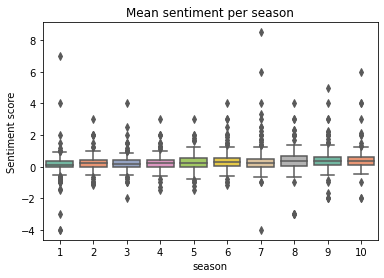

In [97]:
ax = sns.boxplot(x='season', y="scores", data=sentiment_season, palette="Set2", )
ax.set(title ='Mean sentiment per season', ylabel = 'Sentiment score')
plt.show()

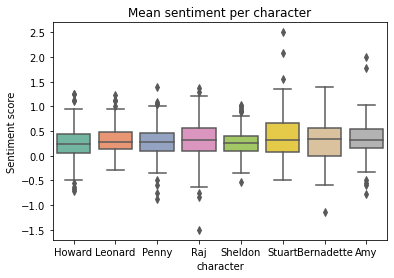

In [100]:
ax = sns.boxplot(x='character', y="scores", data=sentiment_season[sentiment_season['character'].isin(top)], palette="Set2", )
ax.set(title ='Mean sentiment per character', ylabel = 'Sentiment score')
plt.show()

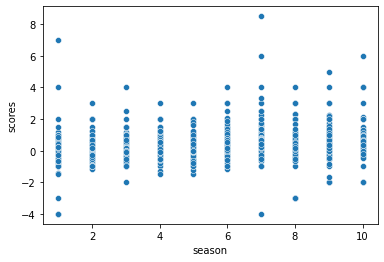

In [102]:
sns.scatterplot(x = 'season', y = 'scores', data = sentiment_season)

### 4 Topic

In [10]:
df.head()

,episode_nr,season,season_episode,episode_id,episode_name,character,location,line,line_id
0,1,1,1,1-1,Pilot Episode,Sheldon,A corridor at a sperm bank.,So if a photon is directed through a plane wit...,1
1,1,1,1,1-1,Pilot Episode,Leonard,A corridor at a sperm bank.,"Agreed, what’s your point?",2
2,1,1,1,1-1,Pilot Episode,Sheldon,A corridor at a sperm bank.,"There’s no point, I just think it’s a good ide...",3
3,1,1,1,1-1,Pilot Episode,Leonard,A corridor at a sperm bank.,Excuse me?,4
4,1,1,1,1-1,Pilot Episode,Receptionist,A corridor at a sperm bank.,Hang on.,5


#### **Pre-processing 1**

In [ ]:
cleaned_df = df.copy()

In [58]:
nltk_st = stopwords.words('english')
spacy_st = nlp.Defaults.stop_words  #from spacy.lang.en.stop_words import STOP_WORDS  is the same

def clean(text, http = True, punc = True, lem = True, stop_w = True):
    
    if http is True:
        text = re.sub("https?:\/\/t.co\/[A-Za-z0-9]*", '', text)

    # stop words
    # in here I changed the placement of lower for those of you who want to use
    # Cased BERT later on.
    if stop_w == 'nltk':
        text = [word for word in word_tokenize(text) if not word.lower() in nltk_st]
        text= ' '.join(text)

    elif stop_w == 'spacy':
        text = [word for word in word_tokenize(text) if not word.lower() in spacy_st]
        text= ' '.join(text)

    # lemmitizing
    if lem == True:
        lemmatized = [word.lemma_ for word in nlp(text)]
        text = ' '.join(lemmatized)

    # punctuation removal
    if punc is True:
        text = text.translate(str.maketrans('', '', string.punctuation))
        
    # removing extra space
    text = re.sub("\s+", ' ', text)
    
    return text

#apply function
cleaned_df['cleaned_line_1'] = cleaned_df['line'].apply(lambda x: clean(x, lem = True, stop_w = 'spacy', http = False, punc = True))

#### **Pre-processing 2**

In [107]:
nltk_st = stopwords.words('english')
spacy_st = nlp.Defaults.stop_words  #from spacy.lang.en.stop_words import STOP_WORDS  is the same
nlp = spacy.load('en')

#step 1: pre-process the text
cleaned_df['cleaned_line_2']  = ''

def preprocess (text):
  doc = nlp(text, disable =['ner', 'parser'])
  lemmas = [token.lemma_ for token in doc]
  a_lemmas = [lemma for lemma in lemmas if lemma.isalpha()]
  lowercase = [t.lower() for t in a_lemmas]
  no_stops = [w for w in lowercase if w not in spacy_st]  #here i use spacy
  return ' '.join(no_stops)

#apply function
cleaned_df['cleaned_line_2'] = cleaned_df['line'].apply(preprocess)



In [108]:
cleaned_df.head(20)

,episode_nr,season,season_episode,episode_id,episode_name,character,location,line,line_id,cleaned_line_1,cleaned_line_2
0,1,1,1,1-1,Pilot Episode,Sheldon,A corridor at a sperm bank.,So if a photon is directed through a plane wit...,1,photon direct plane slit slit observe slit s u...,photon direct plane slit slit observe slit uno...
1,1,1,1,1-1,Pilot Episode,Leonard,A corridor at a sperm bank.,"Agreed, what’s your point?",2,agree s point,agree point
2,1,1,1,1-1,Pilot Episode,Sheldon,A corridor at a sperm bank.,"There’s no point, I just think it’s a good ide...",3,s point think s good idea tee shirt,point think good idea tee shirt
3,1,1,1,1-1,Pilot Episode,Leonard,A corridor at a sperm bank.,Excuse me?,4,excuse,excuse
4,1,1,1,1-1,Pilot Episode,Receptionist,A corridor at a sperm bank.,Hang on.,5,hang,hang
5,1,1,1,1-1,Pilot Episode,Leonard,A corridor at a sperm bank.,"One across is Aegean, eight down is Nabakov, t...",6,Aegean Nabakov twenty six mcm fourteen be … fi...,aegean nabakov mcm fourteen finger phylum four...
6,1,1,1,1-1,Pilot Episode,Receptionist,A corridor at a sperm bank.,Can I help you?,7,help,help
7,1,1,1,1-1,Pilot Episode,Leonard,A corridor at a sperm bank.,"Yes. Um, is this the High IQ sperm bank?",8,yes um high IQ sperm bank,yes um high iq sperm bank
8,1,1,1,1-1,Pilot Episode,Receptionist,A corridor at a sperm bank.,"If you have to ask, maybe you shouldn’t be here.",9,ask maybe shouldn t,ask maybe
9,1,1,1,1-1,Pilot Episode,Sheldon,A corridor at a sperm bank.,I think this is the place.,10,think place,think place


In [109]:
cleaned_df.to_csv('processed_cleaned.csv', index=False)

### 4.1 Topic by character

**Gensim**

In [111]:
character = cleaned_df.copy()
character = character.dropna()  #because of pre-processing, some lines no longer contain data

#only keep the main characters
character = character[character['character'].isin(top)]

#groupby
character_grouped = character.groupby(['character'])['cleaned_line_2'].apply(' '.join).reset_index()
character_grouped 


,character,cleaned_line_2
0,Amy,excuse amy farrah fowler sheldon cooper slang ...
1,Bernadette,microbiology understand know study sure like b...
2,Howard,wait till stephen hawking lecture mit creepy c...
3,Leonard,agree point excuse aegean nabakov mcm fourteen...
4,Penny,oh hi hi oh nice oh okay guess new neighbour p...
5,Raj,fantastic unbelievable smooth chopstick pretty...
6,Sheldon,photon direct plane slit slit observe slit uno...
7,Stuart,oh blink twice let know need hello old girl de...


In [112]:

# this library needs a list of documents: easiest way of doing this is to apply a tokenizer
#create a list of each sentence
def preprocessing(text):
     return word_tokenize(text)  #or use sent_tokenize
#apply function
character_grouped ['cleaned_list'] = character_grouped ['cleaned_line_2'].apply(preprocessing)

#turn into a list of lists 
character_list = character_grouped['cleaned_list'].tolist()


In [113]:
#Create a MmCorpus: corpus
dictionary = Dictionary(character_list)
corpus = [dictionary.doc2bow(dialogue) for dialogue in character_list]


**Amy**

In [114]:
# Create a new TfidfModel using the corpus: tfidf
tfidf = TfidfModel(corpus)

# Save the first document: doc
amy = corpus[0]

# Calculate the tfidf weights of doc: tfidf_weights
tfidf_weights = tfidf[amy]


# Sort the weights from highest to lowest: sorted_tfidf_weights
sorted_tfidf_weights = sorted(tfidf_weights, key=lambda w: w[1], reverse=True)

# Print the top 5 weighted words
for term_id, weight in sorted_tfidf_weights[:10]:
    print(dictionary.get(term_id), weight)

bestie 0.1683911307821667
maid 0.15163257747446698
rajesh 0.10899123599655625
flags 0.10715799231592425
fowler 0.10715799231592425
beaker 0.09184970769936364
kätzchen 0.09184970769936364
raggedy 0.09184970769936364
blah 0.08664718712826686
farrah 0.08419556539108335


**Bernadette**

In [117]:
# Create a new TfidfModel using the corpus: tfidf
tfidf = TfidfModel(corpus)

# Save the first document: doc
bernadette = corpus[1]

# Calculate the tfidf weights of doc: tfidf_weights
tfidf_weights = tfidf[bernadette]


# Sort the weights from highest to lowest: sorted_tfidf_weights
sorted_tfidf_weights = sorted(tfidf_weights, key=lambda w: w[1], reverse=True)

# Print the top 5 weighted words
for term_id, weight in sorted_tfidf_weights[:10]:
    print(dictionary.get(term_id), weight)

howie 0.8902005694434543
ee 0.06553128523516263
pew 0.06553128523516263
benadryl 0.03931877114109759
chump 0.03931877114109759
glenn 0.03931877114109759
hottie 0.03931877114109759
howdini 0.03931877114109759
lactate 0.03931877114109759
limbo 0.03931877114109759


**Howard**

In [118]:
# Create a new TfidfModel using the corpus: tfidf
tfidf = TfidfModel(corpus)

# Save the first document: doc
howard = corpus[2]

# Calculate the tfidf weights of doc: tfidf_weights
tfidf_weights = tfidf[howard]


# Sort the weights from highest to lowest: sorted_tfidf_weights
sorted_tfidf_weights = sorted(tfidf_weights, key=lambda w: w[1], reverse=True)

# Print the top 5 weighted words
for term_id, weight in sorted_tfidf_weights[:10]:
    print(dictionary.get(term_id), weight)

ma 0.6586377981943624
bernie 0.14790125400417575
grossman 0.1026448516666539
chka 0.08981424520832215
marcy 0.08981424520832215
katee 0.06415303229165868
brisket 0.05446736783108617
disposal 0.05132242583332695
leak 0.05132242583332695
mano 0.05132242583332695


**Leonard**

In [119]:
# Create a new TfidfModel using the corpus: tfidf
tfidf = TfidfModel(corpus)

# Save the first document: doc
leonard = corpus[3]

# Calculate the tfidf weights of doc: tfidf_weights
tfidf_weights = tfidf[leonard]


# Sort the weights from highest to lowest: sorted_tfidf_weights
sorted_tfidf_weights = sorted(tfidf_weights, key=lambda w: w[1], reverse=True)

# Print the top 5 weighted words
for term_id, weight in sorted_tfidf_weights[:10]:
    print(dictionary.get(term_id), weight)

lot 0.08458877769961919
lesley 0.08265247998758218
mwuh 0.07748669998835829
leslie 0.07706094628026303
surface 0.07309772411926435
radiation 0.06578795170733792
lactose 0.06578795170733792
th 0.06198935999068664
bran 0.06198935999068664
buh 0.06198935999068664


**Penny**

In [120]:
# Create a new TfidfModel using the corpus: tfidf
tfidf = TfidfModel(corpus)

# Save the first document: doc
penny = corpus[4]

# Calculate the tfidf weights of doc: tfidf_weights
tfidf_weights = tfidf[penny]


# Sort the weights from highest to lowest: sorted_tfidf_weights
sorted_tfidf_weights = sorted(tfidf_weights, key=lambda w: w[1], reverse=True)

# Print the top 5 weighted words
for term_id, weight in sorted_tfidf_weights[:10]:
    print(dictionary.get(term_id), weight)

sweetie 0.34122737193628094
kitty 0.2075831336800987
anyways 0.13209835779642645
bup 0.13209835779642645
nebraska 0.1195175618158144
actress 0.10693676583520235
frenzy 0.08806557186428429
purr 0.08011034137504167
kurt 0.08011034137504167
lot 0.07876792372352757


**Raj**

In [121]:
# Create a new TfidfModel using the corpus: tfidf
tfidf = TfidfModel(corpus)

# Save the first document: doc
raj = corpus[5]

# Calculate the tfidf weights of doc: tfidf_weights
tfidf_weights = tfidf[raj]


# Sort the weights from highest to lowest: sorted_tfidf_weights
sorted_tfidf_weights = sorted(tfidf_weights, key=lambda w: w[1], reverse=True)

# Print the top 5 weighted words
for term_id, weight in sorted_tfidf_weights[:10]:
    print(dictionary.get(term_id), weight)

oontz 0.40893189955383846
hee 0.23990671440491856
delhi 0.11995335720245928
claire 0.11573079450400217
emily 0.11088508767123263
dude 0.09978637570606284
india 0.09051843891529196
mummy 0.0872388052381522
limo 0.08178637991076769
brown 0.07024559215525628


**Sheldon**

In [122]:
# Create a new TfidfModel using the corpus: tfidf
tfidf = TfidfModel(corpus)

# Save the first document: doc
sheldon = corpus[6]

# Calculate the tfidf weights of doc: tfidf_weights
tfidf_weights = tfidf[sheldon]


# Sort the weights from highest to lowest: sorted_tfidf_weights
sorted_tfidf_weights = sorted(tfidf_weights, key=lambda w: w[1], reverse=True)

# Print the top 5 weighted words
for term_id, weight in sorted_tfidf_weights[:10]:
    print(dictionary.get(term_id), weight)

lord 0.11250067942187872
flag 0.08489620889551776
remarkable 0.0798391918477849
beverage 0.06932584454935911
flags 0.06895202932308696
agreement 0.06767089114860111
assure 0.06532297514818765
bazinga 0.06162297293276366
fowler 0.05987939388583867
zoom 0.05987939388583867


**Stuart**

In [123]:
# Create a new TfidfModel using the corpus: tfidf
tfidf = TfidfModel(corpus)

# Save the first document: doc
stuart = corpus[7]

# Calculate the tfidf weights of doc: tfidf_weights
tfidf_weights = tfidf[stuart]


# Sort the weights from highest to lowest: sorted_tfidf_weights
sorted_tfidf_weights = sorted(tfidf_weights, key=lambda w: w[1], reverse=True)

# Print the top 5 weighted words
for term_id, weight in sorted_tfidf_weights[:10]:
    print(dictionary.get(term_id), weight)

debbie 0.22478223129954847
deb 0.16858667347466136
heeled 0.16858667347466136
jesse 0.16858667347466136
tigger 0.16858667347466136
graphic 0.11927823242266188
decaf 0.11239111564977423
quois 0.11239111564977423
halley 0.09526157238297152
therapist 0.08429333673733068
